In [1]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

import time
import os
import re
import pandas as pd
import random

import matplotlib as mpl
from matplotlib import rc, rcParams

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import multiprocessing
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D, Lambda)
from tensorflow.keras.models     import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import  mean_squared_error as mse_keras
from tensorflow.keras.backend import argmax as argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot
from tensorflow.keras.models import Sequential 

from tensorflow.keras.utils import  to_categorical
from tensorflow import random as randomtf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk
from scipy.stats import pearsonr

from progressbar import ProgressBar
import seaborn as sns

from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem

import ntpath
from scipy.stats import truncnorm

import sys
sys.path.append("./../utils/")
from general import *

""" fix all the seeds,results are still slighthly different """
randomtf.set_seed(1)
os.environ['PYTHONHASHSEED'] = '1'
np.random.seed(42)
random.seed(12345)
from progressbar import ProgressBar
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3667)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

2023-06-08 15:41:32.302960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 15:41:32.454017: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 15:41:33.043601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-06-08 15:41:33.043653: W tensorflow/compile

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-06-08 15:41:34.493236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 15:41:34.509347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:41:34.514097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:41:34.514220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

2023-06-08 15:41:34.974611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:41:34.975014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:41:34.975085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-08 15:41:34.975142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21818 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
tf.compat.v1.keras.backend.clear_session()

Text(0.5, 0, '!!!Ariaaaal')

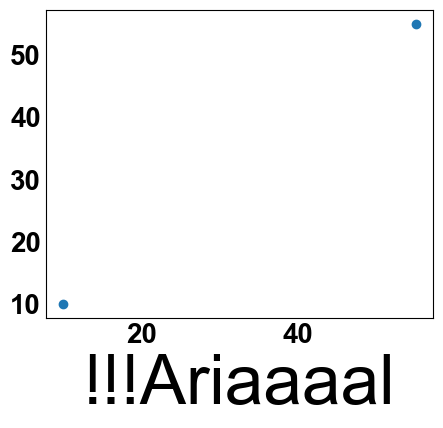

In [4]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [5]:
tf.compat.v1.keras.backend.clear_session()
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

In [6]:
with open('./../data/trainingsets/highgap_outliergen_trans1/image.pickle', 'rb') as f:
    X_smiles_gen, SMILES_gen, y_gen = pickle.load(f) 
    
with open('./../data/trainingsets/highgap_outliergen_trans1/image_train.pickle', 'rb') as f:
    X_smiles_train_gen, SMILES_train_gen, y_train_gen = pickle.load(f)
    
with open('./../data/trainingsets/highgap_outliergen_trans1/image_test.pickle', 'rb') as f:
    X_smiles_val_gen, SMILES_val_gen, y_val_gen = pickle.load(f)

In [7]:
SMILES_gen = np.array (SMILES_gen)
y_gen = np.array (y_gen)

In [8]:
with open('./../data/trainingsets/highgap_pubqc/image.pickle', 'rb') as f:
    X_smiles_pubqc, SMILES_pubqc, y_pubqc = pickle.load(f) 
    
with open('./../data/trainingsets/highgap_pubqc/image_train.pickle', 'rb') as f:
    X_smiles_train_pubqc, SMILES_train_pubqc, y_train_pubqc = pickle.load(f) 
    
with open('./../data/trainingsets/highgap_pubqc/image_test.pickle', 'rb') as f:
    X_smiles_val_pubqc, SMILES_val_pubqc, y_val_pubqc = pickle.load(f) 

In [9]:
y_pubqc.shape

(861,)

In [10]:
X_smiles00 = np.concatenate ((X_smiles_pubqc, X_smiles_gen), axis=0)
SMILES00 = np.concatenate ((SMILES_pubqc, SMILES_gen), axis=0)
y_gantrain000 = np.concatenate ((y_pubqc, y_gen), axis=0)
print (y_gantrain000.shape)
print (X_smiles00.shape)

(5211,)
(5211, 40, 27, 1)


In [11]:
X_smiles0 = np.concatenate((X_smiles00, 
                            X_smiles00[y_gantrain000>10.2], 
                            X_smiles00[y_gantrain000>10.2], 
                            X_smiles00[y_gantrain000>10.2], 
                            X_smiles00[y_gantrain000>10.5], ), axis=0)
SMILES0 = np.concatenate((SMILES00, 
                          SMILES00[y_gantrain000>10.2], 
                          SMILES00[y_gantrain000>10.2],
                          SMILES00[y_gantrain000>10.2], 
                          SMILES00[y_gantrain000>10.5]), axis=0)
y_gantrain00 = np.concatenate((y_gantrain000, 
                               y_gantrain000[y_gantrain000>10.2], 
                               y_gantrain000[y_gantrain000>10.2],
                               y_gantrain000[y_gantrain000>10.2], 
                               y_gantrain000[y_gantrain000>10.5]), axis=0)


In [12]:
print (SMILES0.shape)
y_gantrain0 = y_gantrain00[y_gantrain00<=13]
X_smiles = X_smiles0[y_gantrain00<=13]
SMILES = SMILES0[y_gantrain00<=13]
print (SMILES.shape)

(6233,)
(6233,)


In [13]:
X_smiles_train00 = np.concatenate ((X_smiles_train_pubqc, X_smiles_train_gen), axis=0)
SMILES_train00 = np.concatenate ((SMILES_train_pubqc, SMILES_train_gen), axis=0)
y_train000 = np.concatenate ((y_train_pubqc, y_train_gen), axis=0)
print (y_train000.shape)
print (X_smiles_train00.shape)

(4168,)
(4168, 40, 27, 1)


In [14]:
X_smiles_train0 = np.concatenate((X_smiles_train00, 
                                  X_smiles_train00[y_train000>10.2],
                                  X_smiles_train00[y_train000>10.2],
                                  X_smiles_train00[y_train000>10.2],
                                  X_smiles_train00[y_train000>10.5],), axis=0)
SMILES_train0 = np.concatenate((SMILES_train00, 
                                SMILES_train00[y_train000>10.2],
                                SMILES_train00[y_train000>10.2],
                                SMILES_train00[y_train000>10.2],
                                SMILES_train00[y_train000>10.5],), axis=0)

y_train00 = np.concatenate((y_train000, 
                                y_train000[y_train000>10.2],
                                y_train000[y_train000>10.2],
                                y_train000[y_train000>10.2],
                                y_train000[y_train000>10.5],), axis=0)


In [15]:
y_train0 = y_train00[y_train00<=13]
X_smiles_train = X_smiles_train0[y_train00<=13]
SMILES_train = SMILES_train0[y_train00<=13]
SMILES_train.shape

(5004,)

In [16]:
X_smiles_val00 = np.concatenate ((X_smiles_val_pubqc, X_smiles_val_gen), axis=0)
SMILES_val00 = np.concatenate ((SMILES_val_pubqc, SMILES_val_gen), axis=0)
y_val000 = np.concatenate ((y_val_pubqc, y_val_gen), axis=0)
print (y_val000.shape)
print (X_smiles_val00.shape)

(1043,)
(1043, 40, 27, 1)


In [17]:
X_smiles_val0 = np.concatenate((X_smiles_val00, 
                                  X_smiles_val00[y_val000>10.2],
                                  X_smiles_val00[y_val000>10.2],
                                  X_smiles_val00[y_val000>10.2],
                                  X_smiles_val00[y_val000>10.5],), axis=0)
SMILES_val0 = np.concatenate((SMILES_val00, 
                                SMILES_val00[y_val000>10.2],
                                SMILES_val00[y_val000>10.2],
                                SMILES_val00[y_val000>10.2],
                                SMILES_val00[y_val000>10.5], ), axis=0)

y_val00 = np.concatenate((y_val000, 
                                y_val000[y_val000>10.2],
                                y_val000[y_val000>10.2],
                                y_val000[y_val000>10.2],
                                y_val000[y_val000>10.5],), axis=0)

In [18]:
y_val0 = y_val00[y_val00<=13]
X_smiles_val = X_smiles_val0[y_val00<=13]
SMILES_val = SMILES_val0[y_val00<=13]
SMILES_val.shape

(1229,)

<Axes: ylabel='Count'>

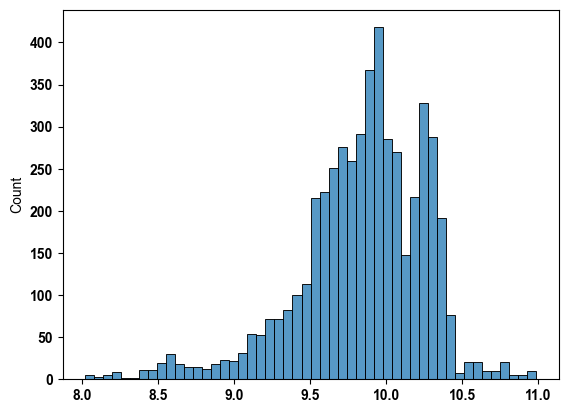

In [19]:
sns.histplot(y_train0)

In [20]:
# Standardized between 0 and 11
gap_min = 0
gap_max = 15

y_val = NormalizeData(y_val0, min_data=gap_min, max_data=gap_max)
y_train = NormalizeData(y_train0, min_data=gap_min, max_data=gap_max)
y_gantrain = (y_gantrain0 - gap_min) / (gap_max - gap_min)

print (np.max(y_val))
print (np.max(y_train))

print (np.min(y_val))
print (np.min(y_train))

print (np.min(y_gantrain))
print (np.max(y_gantrain))

0.7102
0.7323333333333333
0.5351030666666666
0.5345225333333333
0.5345225333333333
0.7323333333333333


In [21]:
np.argmax(y_gantrain0)
print (SMILES[1122])

CCCCCC(C)CC(C)CCCC(C)(C)C.


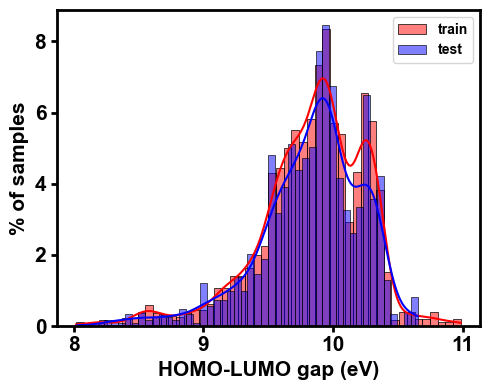

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.tick_params(axis='both', length=4, width=2, colors='black', grid_alpha=0, labelsize=15)
[i.set_linewidth(2) for i in ax.spines.values()]
plt.xlabel('HOMO-LUMO gap (eV)', fontname='Arial', fontweight = 'bold', fontsize=15)
plt.ylabel('% of samples', fontname='Arial', fontweight = 'bold', fontsize=15)

sns.histplot (y_train0, color='red', label='train', stat='percent', kde=True, bins=50)
sns.histplot (y_val0, color='blue', label='test', stat='percent', kde=True, bins=50, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('gap_val_train.jpeg', dpi=500)

In [23]:
""" models definition and extracting pretrained encoder and decoder """
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')

class Config:
    
    def __init__(self):
        self.Filters = [256, 128, 64]
        self.genFilters = [128, 128, 128]
        self.upFilters = [(2, 2), (2, 2), (2, 2)]
        
config = Config()

## Generator 
z = Input(shape = (128, ))
y = Input(shape = (1, ))

h = Concatenate(axis = 1)([z, y])
h = Dense(1 * 1 * 128)(h)
R1 = Reshape([1, 1, 128])(h)
R2 = Reshape([1, 1, 128])(h)

for i in range(3):
    R1 = UpSampling2D(size = config.upFilters[i])(R1)
    C1 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R1)
    B1 = BatchNormalization()(C1)
    R1 = LeakyReLU(alpha=0.2)(B1)

for i in range(3):
    R2 = UpSampling2D(size = config.upFilters[i])(R2)
    C2 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R2)
    B2 = BatchNormalization()(C2)
    R2 = LeakyReLU(alpha=0.2)(B2)
    
R1 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R1)
R2 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R2)

generator0 = Model([z, y], [R1, R2])
print (generator0.summary())

## Discriminator 
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

X1 = Concatenate()([inp1, inp2])
X = Flatten()(X1)
y2 = Concatenate(axis = 1)([X, y])
for i in range(3):
		y2 = Dense(64, activation = 'relu')(y2)
		y2 = LeakyReLU(alpha = 0.2)(y2)
		y2 = Dropout(0.2)(y2)

O_dis = Dense(1, activation = 'sigmoid')(y2)


discriminator0 = Model([inp1, inp2, y], O_dis)
discriminator0.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 5e-5, beta_1 = 0.5))
print (discriminator0.summary()) 

## Regressor
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

yr = Concatenate()([inp1, inp2])

tower0 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(yr)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(yr)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

yr = Flatten()(h)
o = Dropout(0.2)(yr)
o = Dense(128)(o)

o_reg = Dropout(0.2)(o)
o_reg = Dense(1, activation = 'sigmoid')(o_reg)

regressor0 = Model([inp1, inp2], o_reg)
regressor_top0 = Model([inp1, inp2], o)

2023-06-06 15:55:06.388464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 15:55:06.388653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 15:55:06.388716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 15:55:06.388919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 15:55:06.388984: I tensorflow/compiler/xla/stream_executo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 129)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          16640       ['concatenate[0][0]']        

None
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 6, 6, 2)      0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 72)           0           ['concatenate_1[0][0]'

In [24]:
discriminator0 = load_model('./../data/nns/keep/discriminator_15max.h5')
generator0 = load_model('./../data/nns/keep/generator_15max.h5')

discriminator0.trainable=True

In [25]:
# Training the Regressor 
# latent vectors from trained Encoder, 
# last output of Encoder is concat. (O1, O2)
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_embedding, bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_val, bonds_val, _ = encoder.predict([X_smiles_val], verbose=0)

# No training if the trained model is saved. 
try:
    regressor0 = load_model('./../data/nns/keep/regressor_15max.h5')
    regressor_top0 = load_model('./../data/nns/keep/regressor_top_15max.h5')
    regressor0.compile(loss = 'mse', optimizer = Adam(1e-8))
    print (".h5 was read")
except:
    print ("no .h5 available")
    regressor0.compile(loss = 'mse', optimizer = Adam(1e-8))
    pass

2023-06-06 15:55:08.207541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-06 15:55:08.616348: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


.h5 was read


In [26]:
discriminator0.summary(line_length=200)

Model: "model_1"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_3 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                                                
                                                                                                                                                                                                        
 input_4 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                           

In [27]:
discriminator0.trainable = False
generator0.trainable = False

In [28]:
discriminator0.summary(line_length=200)

Model: "model_1"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_3 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                                                
                                                                                                                                                                                                        
 input_4 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                           

In [29]:
generator0.summary(line_length=200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_1 (InputLayer)                                             [(None, 128)]                               0                       []                                                                
                                                                                                                                                                                                        
 input_2 (InputLayer)                                             [(None, 1)]                                 0                       []                                             

In [30]:
regressor_top0.trainable = False
regressor0.trainable = False

In [31]:
generator0.layers.pop()
generator0.layers.pop()

discriminator0.layers.pop()
discriminator0.layers.pop()

In [32]:
regressor0.layers.pop()
regressor0.layers.pop()
regressor0.layers.pop()
regressor0.layers.pop()
regressor0.layers.pop()

In [33]:
regressor0.summary(line_length=200)

Model: "model_2"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_5 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                                                
                                                                                                                                                                                                        
 input_6 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                           

In [34]:
new_dense_generator1 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh', name='mydense1')(generator0.layers[-3].output)

new_dense_generator2 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh', name='mydense2')(generator0.layers[-4].output)

inp_gen = generator0.input
generator = Model([inp_gen[0], inp_gen[1]], [new_dense_generator1, new_dense_generator2])
print (generator.summary(line_length=150))

Model: "model_4"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 128)]                    0                 []                                                
                                                                                                                                                      
 input_2 (InputLayer)                            [(None, 1)]                      0                 []                                                
                                                                                                                                                      
 concatenate (Concatenate)                       (None, 129)                 

In [35]:
dis_dense = Dense(1, activation = 'sigmoid', name='mydense')(discriminator0.layers[-2].output)
inp_dist = discriminator0.input
discriminator = Model([inp_dist[0], inp_dist[1], inp_dist[2]], dis_dense, name='discriminator')
print (discriminator.summary())

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 6, 6, 2)      0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 72)           0           ['concatenate_1[0][0]

In [36]:
new_layer1 = Dense(128, name='mydense1')(regressor0.layers[-4].output)
new_layer2 = Dropout(0.2, name='mydrop')(new_layer1)
new_layer3 = Dense(1, activation = 'sigmoid', name='mydense2')(new_layer2)
inp = regressor0.input
regressor = Model(inp, new_layer3, name='regressor')
regressor.summary(line_length=150)

Model: "regressor"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_5 (InputLayer)                            [(None, 6, 6, 1)]                0                 []                                                
                                                                                                                                                      
 input_6 (InputLayer)                            [(None, 6, 6, 1)]                0                 []                                                
                                                                                                                                                      
 concatenate_3 (Concatenate)                     (None, 6, 6, 2)           

In [37]:
regressor = load_model('./../data/nns/keep/regressor_trans.h5')
regressor.compile(loss = 'mse', optimizer = Adam(1e-6))
regressor0.trainable=False
regressor.summary(line_length=150)

history = regressor.fit([atoms_embedding, bonds_embedding], 
              y_train,
              validation_data = ([atoms_val,
                                  bonds_val],
                                 y_val),
              batch_size=8,
              epochs=1,
              verbose=1)
    
# Validating the regressor
# Train
pred_train = regressor.predict([atoms_embedding, bonds_embedding])
pred_train0 = pred_train*(gap_max-gap_min)+gap_min
print('Current R2 on Regressor for train data: {}'.format(r2_score(y_train0, pred_train0.reshape([-1]))))
mse_train = mean_squared_error(y_train0, pred_train0.reshape([-1]))
mae_train = mean_absolute_error(y_train0, pred_train0.reshape([-1]))

#print ('prediction on train: ', pred_train)
#print ('True train: ', y_train)

# Test
pred = regressor.predict([atoms_val, bonds_val])
pred0 = pred*(gap_max-gap_min) + gap_min
print('Current R2 on Regressor for test data: {}'.format(r2_score(y_val0, pred0.reshape([-1]))))
mse_val = mean_squared_error (y_val0, pred0.reshape([-1]))
mae_val = mean_absolute_error (y_val0, pred0.reshape([-1]))

#print ("prediction on test: ", pred )
#print ("True test values: ", y_val)

print ('Train MSE: {}, RMSE: {}, MAE: {}'.format (round(mse_train, 5), 
                                                  round(mse_train**0.5, 5), 
                                                  round(mae_train, 5)))
print ('Test MSE: {}, RMSE: {}, MAE: {}'.format (round(mse_val, 5), 
                                                  round(mse_val**0.5, 5), 
                                                  round(mae_val, 5)))
# Saving the currently trained models
regressor.save('./../data/nns/regressor_trans.h5')
#regressor_top.save('./../data/nns/regressor_top_trans.h5')

# save the losses 
with open ('regressor_loss_0_150.csv', 'w') as f:
    for key in history.history.keys():
        f.write("%s,%s\n"%(key,history.history[key]))

Model: "model_2"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_5 (InputLayer)                            [(None, 6, 6, 1)]                0                 []                                                
                                                                                                                                                      
 input_6 (InputLayer)                            [(None, 6, 6, 1)]                0                 []                                                
                                                                                                                                                      
 concatenate_3 (Concatenate)                     (None, 6, 6, 2)             

2023-06-06 15:55:13.406527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-06 15:55:13.408273: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2148f6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 15:55:13.408291: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-06 15:55:13.411115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-06 15:55:13.447624: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-06 15:55:13.471455: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once f

157/157 [==============================] - 0s 2ms/step
Current R2 on Regressor for train data: 0.8559910351422817
39/39 [==============================] - 0s 2ms/step
Current R2 on Regressor for test data: 0.5316471671822913
Train MSE: 0.0253, RMSE: 0.15905, MAE: 0.11589
Test MSE: 0.07553, RMSE: 0.27483, MAE: 0.19403


In [38]:
regressor.summary(line_length=100)

Model: "model_2"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 input_5 (InputLayer)            [(None, 6, 6, 1)]     0           []                               
                                                                                                    
 input_6 (InputLayer)            [(None, 6, 6, 1)]     0           []                               
                                                                                                    
 concatenate_3 (Concatenate)     (None, 6, 6, 2)       0           ['input_5[0][0]',                
                                                                    'input_6[0][0]']                
                                                                                                    
 conv2d_9 (Conv2D)               (None, 6, 6, 64)      192         ['conca

In [39]:
#regressor = load_model('./../data/nns/keep/regressor.h5')
with open('./../data/trainingsets/image.pickle', 'rb') as f:
    X_smiles_original, _, y_original0 = pickle.load(f) 
# Training the Regressor 
# latent vectors from trained Encoder, 
# last output of Encoder is concat. (O1, O2)

train_atoms_embedding_try, train_bonds_embedding_try, _ = encoder.predict([X_smiles_original], verbose=0)
pred_original = regressor.predict([train_atoms_embedding_try, train_bonds_embedding_try])
pred_original0 = pred_original*(gap_max-gap_min) + gap_min

print('pearsonr on original data: {}'.format(r2_score(y_original0, pred_original0.reshape([-1]))))
print('MAE on original data: {}'.format(mean_absolute_error(y_original0, pred_original0.reshape([-1]))))

4145/4145 [==============================] - 8s 2ms/step
pearsonr on original data: 0.947026513714782
MAE on original data: 0.3533668095436814


In [40]:
from scipy.stats import pearsonr
print('pearsonr on original data: {}'.format(pearsonr(y_original0, pred_original0.reshape([-1]))))

pearsonr on original data: PearsonRResult(statistic=0.9831084475313566, pvalue=0.0)


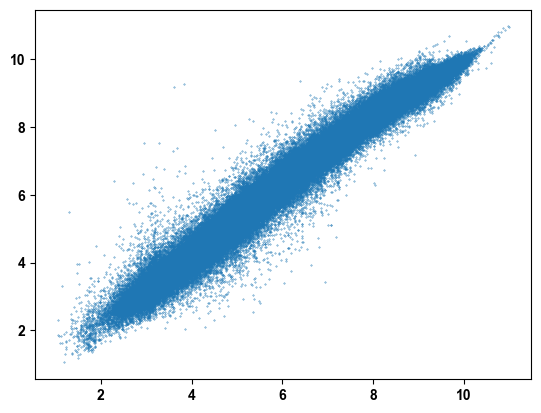

In [41]:
plt.scatter (y_original0, pred_original0.reshape([-1]), s=0.1)

In [42]:
print('Current R2 on Regressor for test data: {}'.format(r2_score(y_val0, pred0.reshape([-1]))))

Current R2 on Regressor for test data: 0.5316471671822913


In [43]:
pred0

array([[10.352751],
       [ 9.899213],
       [10.010871],
       ...,
       [10.353143],
       [ 9.899711],
       [10.197326]], dtype=float32)

In [44]:
print (np.max(y_train0))
print (np.max(pred_train0))
print (np.max(y_val0))
print (np.max(pred0))

10.985
10.964173
10.653
10.539747


In [45]:
MAE_pred_des = np.round (mean_absolute_error(pred0, y_val0), 4)
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, true in zip(pred0, y_val0):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(pred-true)/true
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/(pred0.shape[0])
print ("MAEF_pred_des", Fractioned_MAE_pred_des)

MAE_pred_des 0.194
MAEF_pred_des [0.01998393]


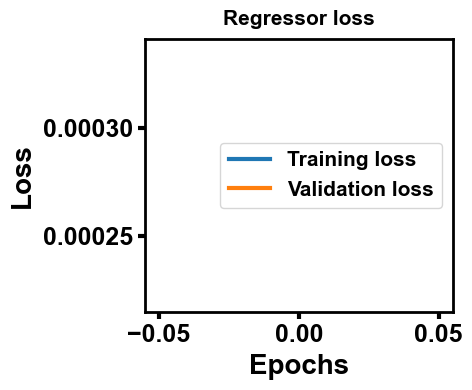

In [46]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(list(range(len(history.history['loss']))), 
         history.history['loss'], label='Training loss', linewidth=3,) 
plt.plot(list(range(len(history.history['val_loss']))), 
         history.history['val_loss'], label='Validation loss', linewidth=3,) 

ax.set_xlabel('Epochs', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Loss', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=1, labelsize='18')

[i.set_linewidth(2) for i in ax.spines.values()]


#plt.title ('per {}, rand {}'.format(per, rand))

#plt.ylim(0, 12)
#plt.xticks((1, 3, 5, 7, 9,  11));
#plt.yticks((1, 3, 5, 7, 9,  11));
plt.title('Regressor loss', fontsize=15, fontname='Arial', fontweight='bold', pad=10)
plt.legend(fontsize=15) 
plt.tight_layout()
plt.savefig("R_loss_0_100.png", dpi=300)

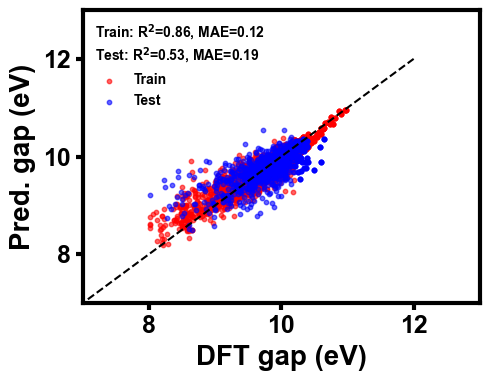

In [47]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams["legend.markerscale"] = 1

plt.scatter (y_train0, pred_train0, color='red', label='Train', alpha=0.6, s=10)
plt.scatter ( y_val0, pred0, color='blue', label='Test', alpha=0.6, s=10)

plt.legend()

ax.set_xlabel('DFT gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Pred. gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]
leg = plt.legend(title='Train: R$^2$={}, MAE={} \nTest: R$^2$={}, MAE={}'.\
           format(round(r2_score(y_train0, pred_train0.reshape([-1])), 2), 
                  round (mae_train, 2),
                  round (r2_score(y_val0, pred0.reshape([-1])), 2), 
                  round (mae_val, 2), ), framealpha=0, title_fontsize=10)
leg._legend_box.align = "left"

#plt.title ('per {}, rand {}'.format(per, rand))
plt.xlim(7, 13)
plt.ylim(7, 13)
#plt.xticks((1, 3, 5, 7, 9,  11));
#plt.yticks((1, 3, 5, 7, 9,  11));
plt.plot([0, 12], [0, 12], '--k', )#color='black')
plt.tight_layout()
plt.savefig('regressor_train_val.jpeg', dpi=300)
plt.rcParams["legend.markerscale"] = 1

In [48]:
np.max(pred_train0)

10.964173

In [107]:
K.clear_session()

In [49]:
## Combined model 
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 5e-5, beta_1 = 0.5))
def build_combined(z, y,
                   regressor,
                   discriminator,
                   encoder,
                   decoder):
    discriminator0.trainable = False
    regressor.trainable = False
    encoder.trainable = False
    decoder.trainable = False
    
    atoms_emb, bonds_emb = generator([z, y])
    dec_embedding = Concatenate()([atoms_emb, bonds_emb])
    
    softmax_smiles, _ = decoder([dec_embedding])
    argmax_smiles = argmax (softmax_smiles, axis=2)
    argmax_smiles = Reshape([40])(argmax_smiles)
    smiles = one_hot(argmax_smiles, depth=27)
    smiles = Reshape([40, 27, 1])(smiles)
    latent_encoder_atom, latent_encoder_bond, _ = encoder ([smiles])
    
    y_pred = regressor([latent_encoder_atom, latent_encoder_bond])
    valid = discriminator([atoms_emb, bonds_emb, y])
    #print ('valid from comb', valid)

    combined = Model([z, y], [valid, y_pred])

    combined.compile(loss = ['binary_crossentropy',
                             'mse'], 
                     loss_weights = [0.01, 25.0], 
                     optimizer = Adam(5e-6, beta_1 = 0.5))
    
    return combined

combined = build_combined(z, y,
                          regressor,
                          discriminator,
                          encoder,
                          decoder)

In [50]:
discriminator.summary(line_length=200)


Model: "discriminator"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_3 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                                                
                                                                                                                                                                                                        
 input_4 (InputLayer)                                             [(None, 6, 6, 1)]                           0                       []                                     

In [110]:
# Train GAN on desired range 9-12
p= multiprocessing.Process()
""" Training RCGAN """
# loading pretrained models
#regressor = load_model    ('./../data/nns/regressor_trans.h5')
#regressor_top = load_model('./../data/nns/regressor_top.h5')

# unfrozen layers of G and D were already read.
#generator = load_model    ('./../data/nns/keep/generator.h5')
#discriminator = load_model ('./../data/nns/keep/discriminator.h5')
#combined = load_model ('./../data/nns/combined.h5')

regressor.trainable = False

# SMILES related information
max_gen_atoms = 9
bond_max = 9
MAX_NB_WORDS = 27
MAX_SEQUENCE_LENGTH = 40


epochs = 4
batch_size = 4
batches = y_train0.shape[0] // batch_size
threshold = 0.2 # defining accurate samples
reinforce_n = 50 # 5*reinforce_n = fake sampling
reinforce_sample = 1000 # how many samples generated for Reinforcement

# variable for storing generated data
G_Losses = []
D_Losses = []
R_Losses = []
D_Losses_real = []
D_Losses_fake = []

for e in range(epochs):
    start = time.time()
    D_loss = []
    G_loss = []
    R_loss = []
    D_loss_real = []
    D_loss_fake = []
    
    for b in range(batches):
        

        regressor.trainable = False

        idx = np.arange(b * batch_size, (b + 1) * batch_size)
        # rearrange the samples 
        idx = np.random.choice(idx, batch_size, replace = False)
        
        x_smiles_train = X_smiles_train[idx] 
        batch_y = y_gantrain[idx]
        
        batch_z = np.random.normal(0, 1, size = (batch_size, 128))
        
        atoms_embedding, bonds_embedding, _ = encoder.predict([x_smiles_train], verbose=0)
        dec_embedding = np.concatenate([atoms_embedding, bonds_embedding], axis = -1)
        
        gen_atoms_embedding, gen_bonds_embedding = generator.predict([batch_z, batch_y], verbose=0)
        
        gen_dec_embedding = np.concatenate([gen_atoms_embedding, gen_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(gen_dec_embedding, verbose=0)[0]
        
        argmax_smiles = np.argmax(softmax_smiles, axis = 2)
        smiles = to_categorical(argmax_smiles, num_classes=27)
        SHAPE = list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
        gen_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
        
        regressor.trainable = True
        r_loss = regressor.train_on_batch([atoms_embedding, bonds_embedding], batch_y)
        R_loss.append(r_loss)
        regressor.trainable = False

        discriminator.trainable = True
        discriminator0.trainable = False
        # original was 3!
        d = 3
        #if b<100:
        #    d=1
        for _ in range(d):
            d_loss_real = discriminator.train_on_batch([atoms_embedding, bonds_embedding, batch_y],
                                                       [0.9 * np.ones((batch_size, 1))])
            d_loss_fake = discriminator.train_on_batch([gen_atoms_embedding, gen_bonds_embedding, batch_y],
                                                       [np.zeros((batch_size, 1))]) 

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        D_loss.append(d_loss)
        D_loss_real.append (d_loss_real)
        D_loss_fake.append (d_loss_fake)
        discriminator.trainable = False
        

        regressor.trainable = False

        #for _ in range(d):
        g_loss = combined.train_on_batch([batch_z, batch_y], [0.9 * np.ones((batch_size, 1)), batch_y])
        
        G_loss.append(g_loss[0])
    
    D_Losses.append(np.mean(D_loss))
    D_Losses_real.append(np.mean(D_loss_real))
    D_Losses_fake.append(np.mean(D_loss_fake))
    G_Losses.append(np.mean(G_loss))
    R_Losses.append(np.mean(R_loss))
    
    print('====')
    print('Current epoch: {}/{}'.format((e + 1), epochs))
    print ('D Loss Real: {}'.format(np.mean(D_loss_real)))
    print ('D Loss Fake: {}'.format(np.mean(D_loss_fake)))
    print('D Loss: {}'.format(np.mean(D_loss)))
    print('G Loss: {}'.format(np.mean(G_loss)))
    print('R Loss: {}'.format(np.mean(R_loss)))
    print('====')
    print()

    
    # Reinforcement
    gen_error = []
    gen_smiles = []
    gen_valid_smiles = []
    gen_X_atoms = []
    gen_X_bonds = []
    predcv_AE_latent = []
    embeddings = []
    sample_ys = []
    valid_smiles_index = []
    for _ in range(reinforce_sample):
        # train only on data between 9 and 12
        sample_y = np.random.uniform(8, 13, size = [1, ])
        sample_y = np.round(sample_y, 4)
        sample_y = (sample_y - gap_min) / (gap_max - gap_min)
        sample_ys.append(sample_y)

        sample_z = np.random.normal(0, 1, size = (1, 128))

        sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y], verbose=0)
        embeddings.append((sample_atoms_embedding, sample_bonds_embedding))
        
        dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2).reshape([-1])
        smiles = to_categorical(argmax_smiles, num_classes=27)
        SHAPE = [1] + list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        c_smiles = ''
        for s in argmax_smiles:
            c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
        
        gen_smiles.append(c_smiles)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
        reg_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0)
        
        pred, desire = reg_pred[0][0], sample_y[0]
        gen_error.append(round (np.abs((pred - desire) / desire), 5)) #!!!!!!!!!!!!! chenge it to desire

        
    gen_error = np.asarray(gen_error).reshape(-1, 1)
    # two validity defined: 

    # without sanitizing: valid 0    
    valid = 0
    valid0 = 0
    idx_ = []
    idx0_ = []
    preds_can = []
    for iter_, smiles in enumerate(gen_smiles):
        if ' ' in smiles[:-1]:
            continue
        m  = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
        m0 = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
        if m0 is not None:
            valid0 += 1
            idx0_.append(iter_)
        if m is not None:
            #if len(construct_atomic_number_array(m)) <= 60:
            valid += 1
            idx_.append(iter_)
            #try:
            gen_smiles [iter_] = Chem.MolToSmiles(m, canonical=True)
            smiles_can = Chem.MolToSmiles(m, canonical=True)
            smiles_can_dot = smiles_can + '.'
            X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
            X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
            X_smiles2 = to_categorical(X_smiles1, num_classes=27)
            latent_encoder_atom, latent_encoder_bond, _ = encoder.predict(X_smiles2, verbose=0)
            pred_can = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
            #pred_can = pred_can*15
            preds_can.append(pred_can[0])
            print (Chem.MolToSmiles(m, canonical=True))
            print ("gap_des", sample_ys[iter_])
            print ("error", gen_error[iter_])
            #except:
                #pass
    idx_ = np.asarray(idx_)

    idx0_ = np.asarray(idx0_)
    preds_can = np.array (preds_can).reshape(-1, 1)
    #print('gen error before correction:', gen_error [idx_])
    sample_ys_ = np.array (sample_ys)
    gen_error [idx_] = [(abs(i-j)/j) for i,j in zip(preds_can, sample_ys_[idx_])] 
    #print('gen error after correction:', gen_error [idx_])
    validity = [gen_smiles[jj] for jj in idx0_ ]
    validity = pd.DataFrame(validity)
    validity = validity.drop_duplicates()

    validity_sanitize = [gen_smiles[jj] for jj in idx_ ]
    validity_sanitize = pd.DataFrame(validity_sanitize)
    validity_sanitize = validity_sanitize.drop_duplicates()

    if (e + 1) % 100 == 0:
        reinforce_n += 10

    # invalid smiles:
    fake_indices1 = np.setdiff1d(np.arange(reinforce_sample), np.asarray(idx_))
    fake_indices2 = np.intersect1d(np.where(gen_error > threshold)[0], idx_)
    fake_indices = np.concatenate ((fake_indices1, fake_indices2))
    fake_indices = np.random.choice(fake_indices, reinforce_n * 5, replace = False)

    real_indices_ = np.intersect1d(np.where(gen_error <= threshold)[0], idx_)
    sample_size =  len(real_indices_)
    real_indices = np.random.choice(real_indices_, sample_size, replace = False)
    
    # Activating Reinforcement 
    if e >= 5:
        discriminator.trainable = True
        discriminator0.trainable = False

        regressor.trainable = False
        for real_index in real_indices:
            #real_latent = regressor_top.predict([embeddings[real_index][0], embeddings[real_index][1]])
            _ = discriminator.train_on_batch([embeddings[real_index][0], 
                                              embeddings[real_index][1], 
                                              sample_ys[real_index]],
                                             [1 * np.ones((1, 1))])

        for fake_index in fake_indices:
            #fake_latent = regressor_top.predict([embeddings[fake_index][0], embeddings[fake_index][1]])
            _ = discriminator.train_on_batch([embeddings[fake_index][0], 
                                              embeddings[fake_index][1] , 
                                              sample_ys[fake_index]],
                                             [np.zeros((1, 1))])
        discriminator.trainable = False

    # ==== #
    try:
        print('Currently valid SMILES (No chemical_beauty and sanitize off): {}'.format(valid0))
        print('Currently valid SMILES Unique (No chemical_beauty and sanitize off): {}'.format(len(validity)))
        print('Currently valid SMILES Sanitized: {}'.format(valid))
        print('Currently valid Unique SMILES Sanitized: {}'.format(len(validity_sanitize)))
        print('Currently satisfying SMILES: {}'.format(len(real_indices_)))
        print('Currently unique satisfying generation: {}'.format(len(np.unique(np.array(gen_smiles)[real_indices_]))))
        #print('Gen Sample is: {}, for {}'.format(c_smiles, sample_y))
        #print('Predicted val: {}'.format(reg_pred))
        print('====')
        print()
    except:
        pass
    
    if (e + 1) % 5 == 0:
        plt.close()
        fig, ax = plt.subplots(figsize = (12, 10))
        ax.tick_params(axis='both', which='major', labelsize=30)
        plt.plot(G_Losses, color='blue')
        plt.plot(D_Losses, color='red')
        plt.xlabel('epochs', fontsize=35)
        plt.ylabel('loss', fontsize=35)
        mpl.rcParams['axes.linewidth'] = 2.5
        #plt.plot(R_Losses)
        plt.legend(['G Loss', 'D Loss'], fontsize=30)
        plt.savefig("G_D_losses{}.png".format (e+1))
    

    n_unique = len(np.unique(np.array(gen_smiles)[real_indices_]))
    n_valid = valid
    if valid > 450 and n_unique > 350:
        print('Criteria has satisified, training has ended')
        break

    end = time.time()
    print ("time for current epoch: ", (end - start))

    tf.compat.v1.keras.backend.clear_session()
with open('GAN_loss.pickle', 'wb') as f:
    pickle.dump((G_Losses, D_Losses, R_Losses), f)

# Saving the currently trained models
#regressor.save('regressor.h5')
#regressor_top.save('regressor_top.h5')
generator.save('./../data/nns/generator_trans.h5')
discriminator.save('./../data/nns/discriminator_trans.h5')
combined.save('./../data/nns/combined_trans.h5')

p.start()
pred_can
p.join()
print ('Done')

====
Current epoch: 1/4
D Loss Real: 0.49607062277843433
D Loss Fake: 0.12795842179504469
D Loss: 0.31201452228673954
G Loss: 2.228781175865925
R Loss: 0.0006188187915022405
====

CCOC1CCCC[CH]CCCCCC[SH]1C
gap_des [0.61738667]
error [0.32613]
CNOCOCCCSCCCN
gap_des [0.63098]
error [0.26287]
CC(NN)NNCCNNC=O
gap_des [0.60184]
error [0.21374]
C.CCOCC1CCOC(COO)[SH]1C
gap_des [0.7617]
error [0.2991]
N#CCNCCCCCNNNN[N][O]
gap_des [0.80520667]
error [0.51913]
Currently valid SMILES (No chemical_beauty and sanitize off): 10
Currently valid SMILES Unique (No chemical_beauty and sanitize off): 10
Currently valid SMILES Sanitized: 5
Currently valid Unique SMILES Sanitized: 5
Currently satisfying SMILES: 1
Currently unique satisfying generation: 1
====

time for current epoch:  387.4711239337921
====
Current epoch: 2/4
D Loss Real: 0.4525538350847795
D Loss Fake: 0.14345188254169391
D Loss: 0.2980028588132367
G Loss: 1.8263410938491258
R Loss: 0.0005664448335883034
====

CC1C2COC(POO)N(N)N12
gap_des

Done


In [111]:
tf.compat.v1.keras.backend.clear_session()

In [51]:
#encoder = load_model('./../data/nns/encoder_trans.h5')
#decoder = load_model('./../data/nns/decoder_trans.h5')
#model = load_model('./../data/nns/ae_model_trans.h5')

#regressor = load_model    ('./../data/nns/keep/regressor.h5')
#regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
generator = load_model    ('./../data/nns/keep/generator_trans.h5')
discriminator= load_model ('./../data/nns/keep/discriminator_trans.h5')

pbar = ProgressBar()
max = 0.3

randS = []
rsquaredS = []
MAE_S = []
less20RE_perS = []
output_lenS = []
mean_RE_S = []
np.random.seed(0)
sample_yss = np.random.uniform(0, 15, size=150)

for rand in pbar(range(0, 1)):  
    N = 500
    n_sample = 100
    gen_error = []
    gen_smiles = []
    sample_ys = []
    preds = []
  
    predss_can = []
    gen_atoms_embedding = []
    gen_bonds_embedding = []

    regressor.trainable = False
    generator.trainable = False
    discriminator.trainable = False

    np.random.seed(rand)

    pbar = ProgressBar()
    for hc in (pbar(sample_yss)):
        try:
            # get it back to original of s_min to s_max
            #sample_y = np.random.uniform(0, 15, size=[1,])
            sample_y = hc
            #print (sample_y)
            sample_y = np.round(sample_y, 4)
            sample_y = sample_y * np.ones([N, ])
            sample_y_ = (sample_y - gap_min) / (gap_max - gap_min)
            
            sample_z = np.random.normal(0, 1, size = (N, 128))
            
            regressor.trainable = False
            encoder.trainable = False
            decoder.trainable = False

            sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_], verbose=0)
            dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)

            softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
            argmax_smiles = np.argmax(softmax_smiles, axis = 2)
            #print (argmax_smiles)

            #print ('shape argmax_smiles', argmax_smiles.shape)
            smiles = to_categorical(argmax_smiles, num_classes=27)
            
            SHAPE = list(smiles.shape) + [1] 
            
            #print ('shape line 767', SHAPE) 
            smiles = smiles.reshape(SHAPE)

            latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
            pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
            pred = pred * (gap_max - gap_min) + gap_min

            gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])


            smiles = decoder.predict(dec_embedding, verbose=0)[0]
            #print(smiles)
            smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 40)
            

            generated_smiles = []
            
            for S in smiles:
                c_smiles = ''
                for s in S:
                    c_smiles += tokenizer[s]
                c_smiles = c_smiles.rstrip()
                #print (c_smiles)
                generated_smiles.append(c_smiles)
            generated_smiles = np.array(generated_smiles)
            #generated_smiles = generated_smiles [accurate]
            all_gen_smiles = []
            idx = []
            preds_can = []
            for i, smiles in enumerate(generated_smiles):
                all_gen_smiles.append(smiles[:-1])

                if ' ' in smiles[:-1]:
                    continue
                #m = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
                m = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
                if m is not None:
                    
                    smiles_can = Chem.MolToSmiles(m, canonical=True)
                    smiles_can_dot = smiles_can + '.'
                    X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
                    X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
                    X_smiles2 = to_categorical(X_smiles1, num_classes=27)
                    latent_encoder_atom, latent_encoder_bond, _ = encoder.predict(X_smiles2, verbose=0)
                    pred_can = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
                    pred_can = pred_can*15
                    # focus on samples with high gap
                    #if pred_can >10:
                    #print(pred_can[0])
                    preds_can.append(pred_can[0])
                    idx.append(i)


            idx = np.array(idx)
            all_gen_smiles = np.array(all_gen_smiles)
            #print ('all gen smiels shape', all_gen_smiles.shape)
            #print ('gen_errors shape', gen_errors.shape)
            #print (idx)
            gen_smiles.extend(list(all_gen_smiles[idx]))
            gen_error.extend(list(gen_errors[idx]))
            sample_ys.extend(list(sample_y[idx]))
            gen_atoms_embedding.extend(sample_atoms_embedding[idx])
            gen_bonds_embedding.extend(sample_bonds_embedding[idx])
            preds.extend(list(pred[idx]))
            predss_can.extend(list(preds_can))
        except:
            #print('Did not discover SMILES for HC: {}'.format(sample_y))
            pass    

    try:
        output = {}

        for i, s in enumerate (gen_smiles):
            ss = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True), canonical=True)
            gen_smiles[i] = ss

        output['SMILES'] = gen_smiles
        output['des_gap'] = sample_ys
        # More accurate for regressor to predict gap from canonical SMILES
        output['pred_gap'] = predss_can
        #output['Err_pred_des'] = gen_error
        output['Err_pred_des'] = [abs(i- j)/i for i, j in zip(output['des_gap'], output['pred_gap'])]
        output = pd.DataFrame(output)
        output.reset_index(drop = True, inplace = True)
        #if (sum (output['Err_pred_des']<= 0.2))/output.shape[0] > 0.0:
        output.to_csv ('./../experiments/transfer1/trans1_training{}.csv'.format(rand), index=False)
        #print ((sum (output['Err_pred_des']<= 0.2))/output.shape[0] )

        ## Statistics  (# pred=True value, Des=prediction)
        # total # of samples
        N = len(predss_can)
        print ('random seed', rand)

        # Explained Variance R2 from sklearn.metrics.explained_variance_score
        explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
        print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
        rsquared = np.round (r2_score (output['des_gap'], output['pred_gap']), 4)
        print ("r squared r**2", rsquared)

        # mean absolute error 
        MAE_pred_des = np.round (mean_absolute_error(output['pred_gap'], output['des_gap']), 4)
        print ("MAE_pred_des", MAE_pred_des)
        # Fractioned MAE, more normalized
        Fractioned_MAE_pred_des = 0
        for pred, des in zip(output['pred_gap'], output['des_gap']):
            Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
        #print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

        # root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
        RMSE_pred_des = mean_squared_error(output['pred_gap'], output['des_gap'])**0.5
        #print ("RMSE_pred_des", RMSE_pred_des)

        Fractioned_RMSE_pred_des = 0
        for pred, des in zip(output['pred_gap'], output['des_gap']):
            Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
        Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
        #print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

        # do not drop duplicate
        output2 = output.drop_duplicates(['SMILES'])
        output2.reset_index(drop = True, inplace = True)
        #output2.to_csv('./../experiments/regular/Initial_training_nodub.csv', index = False)
        """with open('gen_pickles.pickle', 'wb') as f:
            pickle.dump(gen_unique_pickles, f)
        """
        #print ('% < 20 RE NODUP', sum (output2['Err_pred_des'] < 0.2) / output2['Err_pred_des'].shape[0])
        less20RE_per = np.round ((sum(output['Err_pred_des'] <= 0.2) / output['Err_pred_des'].shape[0]), 4)
        print ('% < 20 RE', less20RE_per)
        output_len = len(output)
        explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
        #print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
        mean_RE = np.round (np.mean (output['Err_pred_des']), 4)
        print ('RE mean', mean_RE)

        randS.append(rand)
        rsquaredS.append(rsquared)
        MAE_S.append(MAE_pred_des)
        less20RE_perS.append(less20RE_per)
        mean_RE_S.append(mean_RE)
        output_lenS.append(output_len)

        if rsquared>max:
            good_rand = rand
            max = rsquared
            best_r2 = rsquared
            print ('best r2', best_r2)
            print ('best random seed', good_rand)
        
        tf.compat.v1.keras.backend.clear_session()
    except:
        pass
    tf.compat.v1.keras.backend.clear_session()

params = {}
params ['rand'] = randS
params ['r2'] = rsquaredS
params ['MAE'] = MAE_S
params ['less20RE_per'] = less20RE_perS
params ['Average_RE'] = mean_RE_S
params ['total_valid'] = output_lenS
params = pd.DataFrame(params)
params.reset_index(drop = True, inplace = True)
params.to_csv ('./gen_params.csv', index=False)

100% |########################################################################|


random seed 0
explained_varice_R2_pred_des -0.0898295094414665
r squared r**2 -0.0958
MAE_pred_des 3.6306
% < 20 RE 0.2846
RE mean 1.911


100% |########################################################################|


In [56]:
np.mean(output)

des_gap         7.963383
pred_gap        8.285600
Err_pred_des    1.911049
dtype: float64

In [57]:
output.to_csv ('./../experiments/regular/regularVStransfer_gapdist/transfer1.csv')

In [58]:
with open('./../data/trainingsets/image.pickle', 'rb') as f:
    _, SMILES_original, y_original = pickle.load(f) 

initial_train = pd.read_csv ('./../experiments/regular/regularVStransfer_gapdist/Initial_training.csv')

In [59]:
np.max(output['pred_gap'])

10.971506

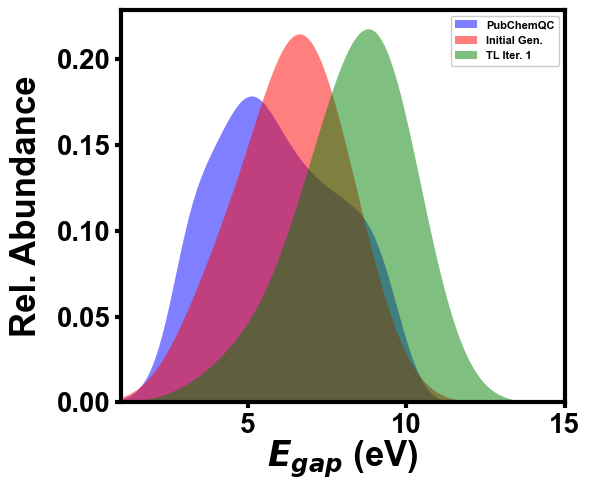

In [60]:
fig, ax = plt.subplots(figsize=(6, 5))

bw_adjust = 3
sns.kdeplot(y_original, bw_adjust=bw_adjust, color='blue', 
            fill=True, label='PubChemQC', linewidth=0, alpha=0.5)
sns.kdeplot(initial_train['pred_gap'], color='red', fill=True,
            bw_adjust=bw_adjust, label='Initial Gen.', linewidth=0, alpha=0.5)
sns.kdeplot(output['pred_gap'], color='green', fill=True, 
            bw_adjust=bw_adjust, label='TL Iter. 1', linewidth=0, alpha=0.5)

plt.xlabel('d', fontsize=20,fontweight='bold', fontname='Arial')
plt.xlim(0, 12)
plt.legend(fontsize=8, framealpha=1)
plt.xlim(1, 15)
plt.xlabel(r'$E_{gap}$ (eV)', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=0)
plt.ylabel('Rel. Abundance', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=20, width=3, length=4)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('genVSpubqc_dist.jpeg', dpi=500)

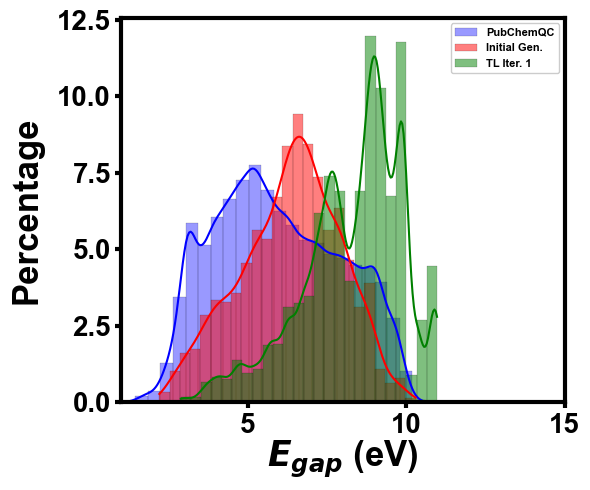

In [61]:
fig, ax = plt.subplots(figsize=(6, 5))

bw_adjust = 3

kwargs1 = dict(kde_kws={'bw_adjust':1})
kwargs2 = dict(kde_kws={'bw_adjust':1})
kwargs3 = dict(kde_kws={'bw_adjust':0.5})

sns.histplot(y_original, color='blue', fill=True, label='PubChemQC', stat='percent', **kwargs1,
             kde=True, bins=25, alpha=0.4, linewidth=0.1)
sns.histplot(initial_train['pred_gap'], color='red', fill=True,  label='Initial Gen.', **kwargs2,
             kde=True, stat='percent', bins=25, linewidth=0.1)
sns.histplot(output['pred_gap'], color='green', fill=True, label='TL Iter. 1', stat='percent', **kwargs3,
             kde=True, bins=25, linewidth=0.1)

plt.xlabel('d', fontsize=20,fontweight='bold', fontname='Arial')
plt.xlim(0, 12)
plt.legend(fontsize=8, framealpha=1)
plt.xlim(1, 15)
plt.xlabel(r'$E_{gap}$ (eV)', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=0)
plt.ylabel('Percentage', fontsize=25, 
           fontname='Arial', fontweight="bold", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=20, width=3, length=4)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('genVSpubqc_dist_exact.jpeg', dpi=500)